### Firstly, we are going to texture a 3D mesh using mayavi lib

In [2]:
from osgeo import gdal
from tvtk.api import tvtk
from mayavi import mlab
import Image
from matplotlib.colors import LightSource

In [3]:
im1 = Image.open("esophagus.jpg")

In [4]:
im2 = im1.rotate(90)
im2.save("tmp/texture6.jpg")

In [5]:
bmp1 = tvtk.JPEGReader(file_name="tmp/texture6.jpg")

In [6]:
my_texture=tvtk.Texture()
my_texture.interpolate=0

In [7]:
# my_texture.set_input(0,bmp1.get_output())
#tvtk.configure_input(my_texture, bmp1)
my_texture=tvtk.Texture(input_connection=bmp1.output_port, interpolate=0)

In [8]:
surf=mlab.pipeline.surface(mlab.pipeline.open("PLY/ASR.ply"))

In [9]:
import numpy as np
surf.scene.camera.view_transform_matrix.to_array().astype(np.float32)

array([[   1.        ,    0.        ,    0.        ,    1.21454477],
       [   0.        ,    1.        ,    0.        ,    4.00613213],
       [   0.        ,    0.        ,    1.        , -186.20892334],
       [   0.        ,    0.        ,    0.        ,    1.        ]], dtype=float32)

In [10]:
surf.scene.get_size()[0]

400

In [11]:
# Create light source object.
ls = LightSource(azdeg=0, altdeg=65)

surf.actor.enable_texture = True
surf.actor.tcoord_generator_mode = 'plane'
surf.actor.actor.texture = my_texture

# Change the visualization parameters.
surf.actor.property.interpolation = 'phong'
surf.actor.property.specular = 0.1
surf.actor.property.specular_power = 5
mlab.show()

In [12]:
surf.scene.camera.view_transform_matrix.to_array().astype(np.float32)

array([[   1.        ,    0.        ,    0.        ,    1.21454477],
       [   0.        ,    1.        ,    0.        ,    4.00613213],
       [   0.        ,    0.        ,    1.        , -186.20892334],
       [   0.        ,    0.        ,    0.        ,    1.        ]], dtype=float32)

### we are going to create two functions which are used to extract matrix:

In [13]:
def modelview_matrix(self):
    r"""
    Retrieves the modelview matrix for this scene.

    :type: ``(4, 4)`` `ndarray`
    """
    camera = self.figure.scene.camera
    return camera.view_transform_matrix.to_array().astype(np.float32)

In [14]:
def projection_matrix(self):
    r"""
    Retrieves the projection matrix for this scene.

    :type: ``(4, 4)`` `ndarray`
    """
    scene = self.figure.scene
    camera = scene.camera
    scene_size = tuple(scene.get_size())
    aspect_ratio = float(scene_size[0]) / float(scene_size[1])
    p = camera.get_projection_transform_matrix(
        aspect_ratio, -1, 1).to_array().astype(np.float32)
    return p

### we are going to smaple images' pixels from images

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

In [16]:
img=mpimg.imread('esophagus.jpg')

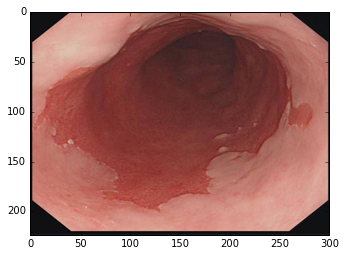

In [17]:
plt.imshow(img)
plt.show()

In [18]:
img.shape

(224L, 300L, 3L)

In [19]:
import random
import cv2
sample_array=[]
r=50
center=[img.shape[0]/2,150]
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if (i-center[0])**2+(j-center[1])**2<=100**2:
            sample_array.append(list(img[i,j,:]))
            
#array=np.array(sample_array)
length=len(sample_array)

constructed_image=[]
for i in range(img.shape[0]):
    temp_array=[]
    for j in range(img.shape[1]):
        randnum=random.randint(0,length-1)
        temp_array.append(sample_array[randnum])
    constructed_image.append(temp_array)
constructed_image=np.array(constructed_image)

In [20]:
blur = cv2.GaussianBlur(constructed_image,(7,7),0)
dst = cv2.fastNlMeansDenoisingColored(blur,None,10,10,7,21)

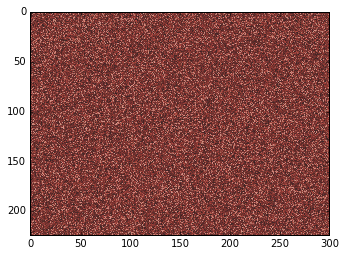

In [21]:
plt.imshow(constructed_image)
plt.show()

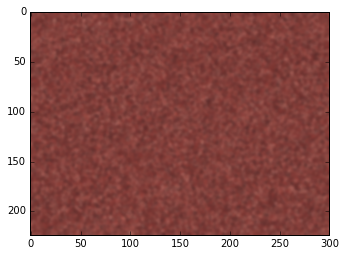

In [22]:
plt.imshow(blur)
plt.show()

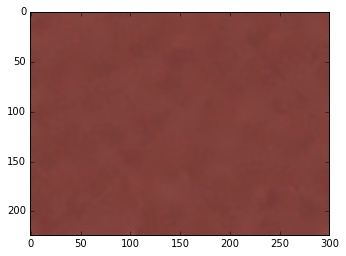

In [23]:
plt.imshow(dst)
plt.show()

In [24]:
import scipy.misc
scipy.misc.imsave('sampled_texture.jpg', blur)

### Now,we are going to use sampled image to texture 3D-mesh 

In [53]:
from osgeo import gdal
from tvtk.api import tvtk
from mayavi import mlab
import Image

im1 = Image.open("sampled_texture.jpg")
im2 = im1.rotate(90)
im2.save("tmp/sampled_texture.jpg")
bmp1 = tvtk.JPEGReader(file_name="tmp/sampled_texture.jpg")

my_texture=tvtk.Texture()
my_texture.interpolate=0
my_texture=tvtk.Texture(input_connection=bmp1.output_port, interpolate=0)

In [54]:
from scipy.spatial import distance
import numpy as np
import codecs, json 

surf=mlab.pipeline.surface(mlab.pipeline.open("PLY/ASR.ply"))

# Change the visualization parameters.
surf.actor.property.interpolation = 'phong'
surf.actor.property.specular = 0.5
surf.actor.property.specular_power = 5

surf.actor.enable_texture = True
surf.actor.tcoord_generator_mode = 'plane'
surf.actor.actor.texture = my_texture

In [55]:
cam1,foc1=mlab.move()
focal_length=distance.euclidean(cam1,foc1)
intrinsic_matrix=[[focal_length,0,surf.scene.get_size()[1]/2],[0,focal_length,surf.scene.get_size()[0]/2],[0,0,1]]

In [ ]:
mlab.view(80,120,45)
surf.scene.camera.elevation(10)
pose, focs = mlab.move()

poses = []
extrinsic_matrices=[]

# Make an animation:
for i in range(200):
    # change distance
    delta = -(float(i)/float(200))*5
    #mlab.view(80,120,45+delta)
    surf.scene.camera.roll(10+delta)
    surf.scene.camera.azimuth(10-delta)
    #fig=mlab.figure(bgcolor=(1,1,1))
    
    cam1,foc1=mlab.move()
    roll = mlab.roll()
    azui = mlab.view()[0]
    elevation = mlab.view()[1]
    temp = list(cam1)+[roll,azui,elevation]
    #print(temp)
    poses.append(temp)
    surf.scene.save_png('test_images/anim%d.png'%i)
dict_test={}
dict_test_poses={}
for i in range(len(poses)):
    dict_test_poses["anim"+str(i)+"_camera_pos"]=poses[i]
dict_test['camera_poses']=dict_test_poses

file_path = "test_images/camera_pose.json" ## your path variable
json.dump(dict_test, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)

In [51]:
mlab.show()


### Hi, I am going to display more images using these codes!!!

In [27]:
cam1,foc1=mlab.move()
focal_length=distance.euclidean(cam1,foc1)
intrinsic_matrix=[[focal_length,0,surf.scene.get_size()[1]/2],[0,focal_length,surf.scene.get_size()[0]/2],[0,0,1]]

In [28]:
mlab.view(90,120,75)

(90.0, 119.99999999999999, 75, array([-1.21454477, -4.00613213,  4.57931805]))

In [29]:
poses=[]
focs=[]
extrinsic_matrices=[]
# Make an animation:
for i in range(10000):
    # change distance
    delta = -(float(i)/float(10000))*36
    mlab.view(80,120,60+delta)
    #fig=mlab.figure(bgcolor=(1,1,1))
    
    cam1,foc1=mlab.move()
    poses.append(cam1)
    focs.append(foc1)
    matrix=surf.scene.camera.view_transform_matrix.to_array().astype(np.float32)
    extrinsic_matrices.append(matrix)
    
    # Save the scene.
    surf.scene.save_png('test_images/anim%d.png'%i)
    #mlab.savefig('test_images/anim%d.png'%i,figure=fig)


In [30]:
mlab.show()

In [31]:
import json


dict_test={}
dict_test_poses={}
for i in range(len(poses)):
    dict_test_poses["anim"+str(i)+"_camera_pose"]=list(poses[i])
dict_test['camera_poses']=dict_test_poses

dict_test_focal_point={}
for i in range(len(poses)):
    dict_test_focal_point["anim"+str(i)+"_focal_point"]=list(focs[i])
dict_test['focal_points']=dict_test_focal_point

file_path = "test_images/camera_pose.json" ## your path variable
json.dump(dict_test, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)


extrinsic={}
extrinsic_intrinsic={}
for i in range(len(extrinsic_matrices)):
    extrinsic["view"+str(i)+"_extrinsic_matrix"]=extrinsic_matrices[i].tolist()
extrinsic_intrinsic['extrinsic_info']=extrinsic
extrinsic_intrinsic['intrinsic_info']=intrinsic_matrix

In [32]:
file_path = "test_images/extrinsic_intrinsic.json" ## your path variable
json.dump(extrinsic_intrinsic, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)

### Now, we are trying to use mayavi to automatically change views of 3D mesh object

In [33]:
from osgeo import gdal
from tvtk.api import tvtk
from mayavi import mlab
import Image

im1 = Image.open("sampled_texture.jpg")
im2 = im1.rotate(90)
im2.save("tmp/sampled_texture.jpg")
bmp1 = tvtk.JPEGReader(file_name="tmp/sampled_texture.jpg")

my_texture=tvtk.Texture()
my_texture.interpolate=0
my_texture=tvtk.Texture(input_connection=bmp1.output_port, interpolate=0)

In [34]:
surf=mlab.pipeline.surface(mlab.pipeline.open("PLY/ASR.ply"))
surf.actor.enable_texture = True
surf.actor.tcoord_generator_mode = 'plane'
surf.actor.actor.texture = my_texture

In [35]:
mlab.show()

In [25]:
from scipy.spatial import distance
import numpy as np
import codecs, json 

poses=[]
focs=[]
extrinsic_matrices=[]

cam1,foc1=mlab.move()
poses.append(cam1)
focs.append(foc1)
focal_length=distance.euclidean(cam1,foc1)
intrinsic_matrix=[[focal_length,0,surf.scene.get_size()[1]/2],[0,focal_length,surf.scene.get_size()[0]/2],[0,0,1]]

# Make an animation:
for i in range(36):
    # Rotate the camera by 10 degrees.
    surf.scene.camera.azimuth(10)

    # Resets the camera clipping plane so everything fits and then
    # renders.
    surf.scene.reset_zoom()
    
    cam1,foc1=mlab.move()
    poses.append(cam1)
    focs.append(foc1)
    matrix=surf.scene.camera.view_transform_matrix.to_array().astype(np.float32)
    extrinsic_matrices.append(matrix)
    
    # Save the scene.
    surf.scene.save_png('saved_images/anim%d.png'%i)

In [26]:
dict_test={}
dict_test_poses={}
for i in range(len(poses)):
    dict_test_poses["anim"+str(i)+"_camera_pose"]=list(poses[i])
dict_test['camera_poses']=dict_test_poses

dict_test_focal_point={}
for i in range(len(poses)):
    dict_test_focal_point["anim"+str(i)+"_focal_point"]=list(focs[i])
dict_test['focal_points']=dict_test_focal_point

file_path = "saved_images/camera_pose.json" ## your path variable
json.dump(dict_test, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)
    
extrinsic={}
extrinsic_intrinsic={}
for i in range(len(extrinsic_matrices)):
    extrinsic["anim"+str(i)+"_extrinsic_matrix"]=extrinsic_matrices[i].tolist()
extrinsic_intrinsic['extrinsic_info']=extrinsic
extrinsic_intrinsic['intrinsic_info']=intrinsic_matrix

file_path = "saved_images/extrinsic_intrinsic.json" ## your path variable
json.dump(extrinsic_intrinsic, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)

In [27]:
mlab.show()

In [28]:
surf.scene.camera.view_transform_matrix.to_array().astype(np.float32)

array([[  1.00000000e+00,   0.00000000e+00,   1.23473835e-15,
          1.21454477e+00],
       [  0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          4.00613213e+00],
       [ -1.23473835e-15,   0.00000000e+00,   1.00000000e+00,
         -1.86208923e+02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]], dtype=float32)